In [2]:
#install.packages("keras")
#install.packages("tfruns")
#install.packages("tfestimators")
#install.packages("dslabs")

In [2]:
rm(list=ls())

In [3]:
# Helper packages
library(readr)
library(dplyr)         # for basic data wrangling
library(ggplot2)
library(gridExtra)
library(recipes)
library(caret)

# Modeling packages
library(keras)         # for fitting DNNs
library(tfruns)        # for additional grid search & model training functions

# Modeling helper package - not necessary for reproducibility
library(tfestimators)  # provides grid search & model training interface

use_python("/home/creyesp/Projects/repos/r-course/venv/bin/python")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘recipes’


The following object is masked from ‘package:stats’:

    step


Loading required package: lattice


Attaching package: ‘tfestimators’


The following object is masked from ‘package:caret’:

    train




# Read Dataset

In [4]:
path_data = '/home/creyesp/Projects/repos/r-course/data/online_shoppers_intention.csv'

categorical = c(
    'Month',
    'VisitorType',
    'OperatingSystems',
    'Browser',
    'Region',
    'TrafficType',
    'Administrative',
    'Informational',
    'ProductRelated',
    'Weekend'
)
numerical = c(
    'Administrative_Duration',
    'Informational_Duration',
    'ProductRelated_Duration',
    'BounceRates',
    'ExitRates',
    'PageValues',
    'SpecialDay'
)
outcome = 'Revenue'

column_parser <- cols(
    Administrative = col_character(),
    Administrative_Duration = col_double(),
    Informational = col_character(),
    Informational_Duration = col_double(),
    ProductRelated = col_character(),
    ProductRelated_Duration = col_double(),
    BounceRates = col_double(),
    ExitRates = col_double(),
    PageValues = col_double(),
    SpecialDay = col_double(),
    Month = col_character(),
    OperatingSystems = col_character(),
    Browser = col_character(),
    Region = col_character(),
    TrafficType = col_character(),
    VisitorType = col_character(),
    Weekend = col_character(),
    Revenue = col_logical()
)

data = readr::read_delim(path_data, delim=',', col_types = column_parser)

# Split train/test

In [5]:
set.seed(42)

index_train <- createDataPartition(data$Revenue, p = 0.8, list = FALSE)
intention_train <- data[index_train, ]
intention_test  <- data[-index_train, ]

head(intention_train)

Warning message:
“The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
0,0,0,0,1,0.000000,0.20,0.20,0,0.0,Feb,1,1,1,1,Returning_Visitor,FALSE,FALSE
0,0,0,0,2,64.000000,0.00,0.10,0,0.0,Feb,2,2,1,2,Returning_Visitor,FALSE,FALSE
0,-1,0,-1,1,-1.000000,0.20,0.20,0,0.0,Feb,4,1,9,3,Returning_Visitor,FALSE,FALSE
0,0,0,0,2,2.666667,0.05,0.14,0,0.0,Feb,3,2,2,4,Returning_Visitor,FALSE,FALSE
0,0,0,0,10,627.500000,0.02,0.05,0,0.0,Feb,3,3,1,4,Returning_Visitor,TRUE,FALSE
0,-1,0,-1,1,-1.000000,0.20,0.20,0,0.4,Feb,2,4,3,3,Returning_Visitor,FALSE,FALSE


# Prepare data

In [6]:
prep_intention <- recipe(Revenue ~ ., data = intention_train) %>%
    step_medianimpute(all_of(numerical)) %>% 
    step_string2factor(all_of(categorical)) %>% 
    step_knnimpute(all_of(categorical)) %>% 
    step_dummy(all_of(categorical), one_hot=TRUE) %>% 
    step_normalize(all_predictors()) %>% 
    step_mutate(Revenue = as.integer(Revenue)) %>% 
    prep()
    
intention_train_clean  <-  bake(prep_intention, intention_train)
intention_test_clean  <-  bake(prep_intention, intention_test)

X_train <- as.matrix(intention_train_clean[setdiff(names(intention_train_clean), "Revenue")])
Y_train <- intention_train_clean$Revenue
X_test <- as.matrix(intention_test_clean[setdiff(names(intention_test_clean), "Revenue")])
Y_test <- intention_test_clean$Revenue

In [18]:
head(X_train)

Administrative_Duration,Informational_Duration,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month_Aug,Month_Dec,Month_Feb,⋯,ProductRelated_X92,ProductRelated_X93,ProductRelated_X94,ProductRelated_X95,ProductRelated_X96,ProductRelated_X97,ProductRelated_X98,ProductRelated_X99,Weekend_FALSE.,Weekend_TRUE.
-0.4529207,-0.2447228,-0.6109873,3.67141570,3.2402525,-0.3129884,-0.3075558,-0.1917819,-0.4022462,8.130322,⋯,-0.02664604,-0.03902164,-0.04030342,-0.04030342,-0.03769657,-0.03769657,-0.04154592,-0.02251773,0.5452645,-0.5452645
-0.4529207,-0.2447228,-0.5783374,-0.45750604,1.1762454,-0.3129884,-0.3075558,-0.1917819,-0.4022462,8.130322,⋯,-0.02664604,-0.03902164,-0.04030342,-0.04030342,-0.03769657,-0.03769657,-0.04154592,-0.02251773,0.5452645,-0.5452645
-0.4585465,-0.2518102,-0.6114975,3.67141570,3.2402525,-0.3129884,-0.3075558,-0.1917819,-0.4022462,8.130322,⋯,-0.02664604,-0.03902164,-0.04030342,-0.04030342,-0.03769657,-0.03769657,-0.04154592,-0.02251773,0.5452645,-0.5452645
-0.4529207,-0.2447228,-0.6096269,0.57472439,2.0018483,-0.3129884,-0.3075558,-0.1917819,-0.4022462,8.130322,⋯,-0.02664604,-0.03902164,-0.04030342,-0.04030342,-0.03769657,-0.03769657,-0.04154592,-0.02251773,0.5452645,-0.5452645
-0.4529207,-0.2447228,-0.2908651,-0.04461387,0.1442418,-0.3129884,-0.3075558,-0.1917819,-0.4022462,8.130322,⋯,-0.02664604,-0.03902164,-0.04030342,-0.04030342,-0.03769657,-0.03769657,-0.04154592,-0.02251773,-1.8337865,1.8337865
-0.4585465,-0.2518102,-0.6114975,3.67141570,3.2402525,-0.3129884,1.6977570,-0.1917819,-0.4022462,8.130322,⋯,-0.02664604,-0.03902164,-0.04030342,-0.04030342,-0.03769657,-0.03769657,-0.04154592,-0.02251773,0.5452645,-0.5452645


In [7]:
n_cols = ncol(X_train)
n_cols

[1] 408

# Neural Networks models (Tensorflow + keras)
Multi-Layer Perceptron / Feed Forward Neural Network
<img src="https://mk0analyticsindf35n9.kinstacdn.com/wp-content/uploads/2018/01/nural-network_3.gif">
https://analyticsindiamag.com/most-common-activation-functions-in-neural-networks-and-rationale-behind-it/

## Hiper-parámetros
* **Hidden Unit**: también conocidas como neuronas, son una función que toma una entrada (ej: features o la salida de la layer anterior) y realiza la suma ponderada (regresión lineal) seguido a una función de activación.
* **Activation Function**Transforma la salida de una neurona, generalmente es una función no lineal. La más famosa de estas funciones es ReLU (Rectified Linear Units), sin embargo hay varias de la misma familia que tratan de resolver algunos problemas que tiene ReLU, PReLU (Parametric Rectified Linear Unit), ELU (Exponential Linear Units) pero un buen inicio es comenzar con ReLU. [Doc](https://tensorflow.rstudio.com/reference/keras/#section-activations)
* **Layer**: es una colección de neuronas que están en el mismo nivel.
* **Loss Function**: Es la función que se usa para medir el error del modelo con el fin de guiar a al modelo a la mejor solución.
  * Para problemas de clasificación binaria: binary cross entropy (log loss)
  * Para problemas de clasificación multiclases: categorical cross entropy
  * Para regresión: MSE/SSE
* **Batch size**: es el tamaño de observaciones que se van a pasar por la red para calcular el error con la loss function para actualizar los pesos de la red. Cuando tenemos dataset muy grande toma una gran ventaja porque podemos posar una pequeña muestra de los datos si tener que tener todo cargado en memoria, además valores más grandes requieren más recursos del sistema y valores bajos podrían hacer el entrenamiento muy ruidoso (trade-off). [Más detalles](https://stats.stackexchange.com/questions/140811/how-large-should-the-batch-size-be-for-stochastic-gradient-descent)
* **Optimizer**: implementacion de SGD que se usará para actualizar los pesos de la red. [full list](https://tensorflow.rstudio.com/reference/keras/#section-optimizers)
* **Learning Rate**: el paso con que SDG va a actualizar los pesos de la red.
* **Epoch**: Número de veces que se pasa el dataset completo en el entrenamiento.
[Practical Recommendations for Gradient-Based Training ofDeepArchitectures](https://arxiv.org/pdf/1206.5533.pdf)

## Valores por defecto

Si bien no hay una regla fija ni un standard para la construcción de las redes neuronales, hay algunos valores empíricos que pueden ser usados en las fases iniciales para luego ir ajustando iterativamente sobre ellos.

* **Número de hidden units**: 128-256 puede ser un buen inicio, entre más grande el número de neuronas más capacidad tiene de aprender relaciones en los datos pero esto a su vez lleva a ser sensible a overfitting, hay que explorar subir o bajar este valor.
* **Activation Function**:  ReLU por simplicidad y eficacia.
* **Número de layers (capas)**: 1 o 2 capas es un buen inicio, si nuestra red tiene un performance bajo quizá aumentar el número de capas pueda ayudar a construir relaciones de los datos.
* **Optimizer**: SGD es el más clásico pero hay varias mejoras para hacer el proceso más dinámico, por ejemplo ADAM, RMSProp o configurar otros parámetros de SGD como nesterov momentum.
* **Learning Rate**: 1e-3 1e-5 seems to be a good place to start. I usually start on the high-end and if the network has trouble learning (e.g. training loss doesn’t go down or bounces wildly), I’ll turn down the learning rate and try again.
* **Batch size** - Depends on problem size and GPU memory, but I typically start with 64-128
* **Epoch**: está directamente relacionado con el learning rate, entre más pequeño es este mayor número de epoch vamos a necesitar para llegar al mínimo del error.


[Activation functions](https://dashee87.github.io/deep%20learning/visualising-activation-functions-in-neural-networks/)   
[Playground tf](https://playground.tensorflow.org/)   

[Documentación Oficial de keras en R](https://tensorflow.rstudio.com/reference/keras/)

## Modelo 1 - Base
### Topología
Primero definimos la topología, en otras palabras la forma en la que se conectan las neuronas, lo cual significa decidir las distintas capas que vamos a usar en nuestra red, el número de neuronas (units) por capa, la relación entre ellas y cuales son las funciones de activación que vamos a usar.

* **keras_mode_secuencial**: cada capa nueva que agregamos se conecta con la anterior secuencialmente
* **layer_dense**: es un tipo de de capa donde cada neurona esa de esa capa están conectadas con todas las neuronas de la capa anterior y la siguiente.
  * **units**: número de neuronas por capa
  * **activation**: funcion de activacion que vamos usar en la salida de cada neurona

Como vimos en [Playground tf](https://playground.tensorflow.org/) las primeras capas capturan información simple, pero a medida que ponemos más capas y nuestra red se hace más profunda es capaz de capturar relaciones más complejas o de más alto nivel

<img src="https://playground.tensorflow.org/preview.png">


In [8]:
model <- keras_model_sequential() %>%
  layer_dense(units = 128, activation = "relu", input_shape = n_cols) %>%
  layer_dense(units = 1, activation = "sigmoid")

In [9]:
summary(model)

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense (Dense)                       (None, 128)                     52352       
________________________________________________________________________________
dense_1 (Dense)                     (None, 1)                       129         
Total params: 52,481
Trainable params: 52,481
Non-trainable params: 0
________________________________________________________________________________


In [10]:
408*128 + 128

[1] 52352

### Entrenar
Después de definir la estructura de nuestra red tenemos que definir cómo vamos a  hacer para que la red ajuste los pesos de cada neurona, para esto necesitamos alguna técnica de optimización. La función más clásica es SGD pero hay muchas más.
* **loss**: función para evaluar que tan bien lo esta haciendo el modelo, para problemas de clasificación binaria usamos la entropía (log loss).
* **optimizer**: función de optimización para ir ajustando los pesos iterativamente en función del resultado de la loss
  * lr: learning rate es un parámetro del optimizador con el que controlamos el paso con el que se actualizan los pesos de la red.
* **metric**: adicionalmente podemos agregar algunas métricas además de la loss para ir viendo la evolución de nuestro modelos a medida que va entrenando, de la mismas forma que lo hicimos con xgboost


In [11]:
model <- model %>% 
  compile(
    loss = 'binary_crossentropy',
    optimizer = optimizer_sgd(lr=0.01),
    metrics = c('accuracy')
  )

Despues de crear el model usamos la funcion `fit` para hacer el entrenamiento

In [12]:
set.seed(42)
history <- model %>%
  fit(
    x = X_train,
    y = Y_train,
    epochs = 25,
    batch_size = 32,
    validation_split = 0.2,
    verbose = 1
  )
history


Final epoch (plot to see history):
        loss: 0.1789
    accuracy: 0.9276
    val_loss: 0.5592
val_accuracy: 0.8322 

Tensorflow te permite ver como fue la evolución de la loss u otra metrica en cada epoch para tener una idea de como la red fue aprendiendo, muy simialr las graficas con XGBoost.

`geom_smooth()` using formula 'y ~ x'



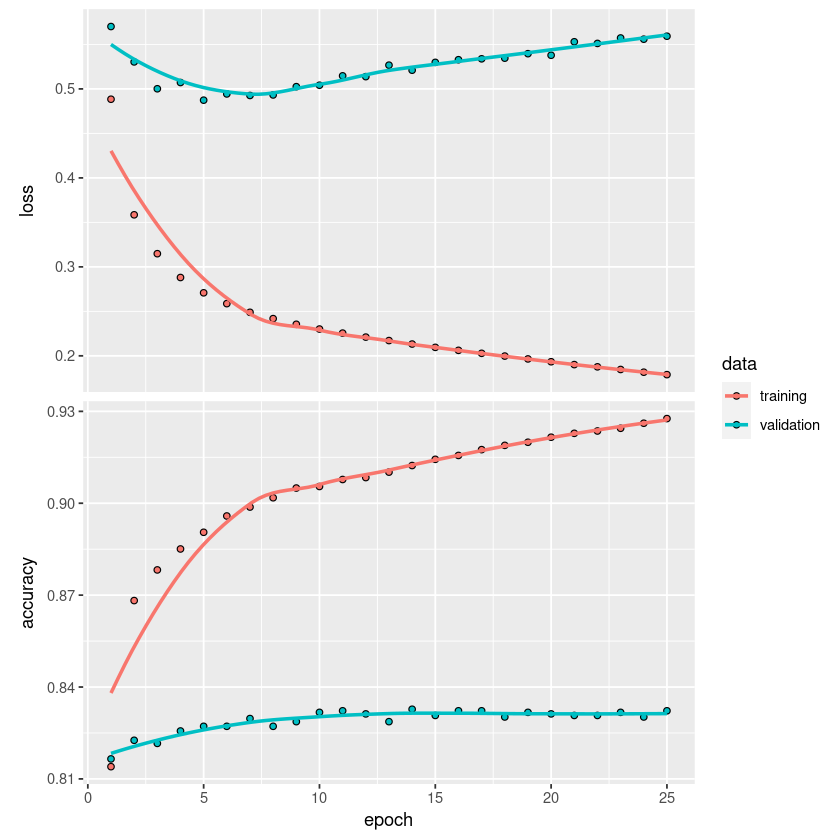

In [13]:
plot(history)

Evaluación en test

In [14]:
model %>% evaluate(X_test, Y_test, batch_size = 128)

loss  accuracy 
0.3558337 0.8774848

### Predictions

In [15]:
# Método genérico para las predicciones
predict(model, X_test, batch_size = 32)[1:5]

# Método para obtener la probabilidad de la predicción
predict_proba(model, X_test)[1:5]

# Método para obtener la clase de la predicción
predict_classes(model, X_test)[1:5]



[1] 0.0117476285 0.0006942153 0.0092175007 0.0095251799 0.0015739799

[1] 0.0117476285 0.0006942153 0.0092175007 0.0095251799 0.0015739799

[1] 0 0 0 0 0

Podemos revisar la matriz de confusion y las otras metricas de clasificación en train y test para ver el performance del modelo

In [16]:
data_to_eval = X_train
real_target = Y_train
pred_intention <- predict(model, data_to_eval)

confusionMatrix(data = as.factor(ifelse(pred_intention>0.5, 1, 0)),
                reference = as.factor(real_target),
                positive='1',
                mode='prec_recall'
               )

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 8139  673
         1  199  854
                                          
               Accuracy : 0.9116          
                 95% CI : (0.9058, 0.9171)
    No Information Rate : 0.8452          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6131          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.81102         
                 Recall : 0.55927         
                     F1 : 0.66202         
             Prevalence : 0.15479         
         Detection Rate : 0.08657         
   Detection Prevalence : 0.10674         
      Balanced Accuracy : 0.76770         
                                          
       'Positive' Class : 1               
                                          

### Evaluación en test

In [17]:
data_to_eval = X_test
real_target = Y_test
pred_intention <- predict(model, data_to_eval)

confusionMatrix(data = as.factor(ifelse(pred_intention>0.5, 1, 0)),
                reference = as.factor(real_target),
                positive='1',
                mode='prec_recall'
               )

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1999  217
         1   85  164
                                          
               Accuracy : 0.8775          
                 95% CI : (0.8639, 0.8902)
    No Information Rate : 0.8454          
    P-Value [Acc > NIR] : 3.354e-06       
                                          
                  Kappa : 0.4539          
                                          
 Mcnemar's Test P-Value : 4.765e-14       
                                          
              Precision : 0.65863         
                 Recall : 0.43045         
                     F1 : 0.52063         
             Prevalence : 0.15456         
         Detection Rate : 0.06653         
   Detection Prevalence : 0.10101         
      Balanced Accuracy : 0.69483         
                                          
       'Positive' Class : 1               
                                          

## Modelo 2

Ahora que sabemos lo basico de como construir una red podemos comenzar a crear diferentes configuraciones y ver cual es la que nos resulta mejor para resolver nuestro problema.   

Esta vez vamos a probar disminuir el numero de neuronas con el fin de forzar a la red a quedarse solo con la informacion necesaria.




Final epoch (plot to see history):
        loss: 0.1922
    accuracy: 0.9225
    val_loss: 0.5699
val_accuracy: 0.8353 

`geom_smooth()` using formula 'y ~ x'



loss  accuracy 
0.3431137 0.8791075

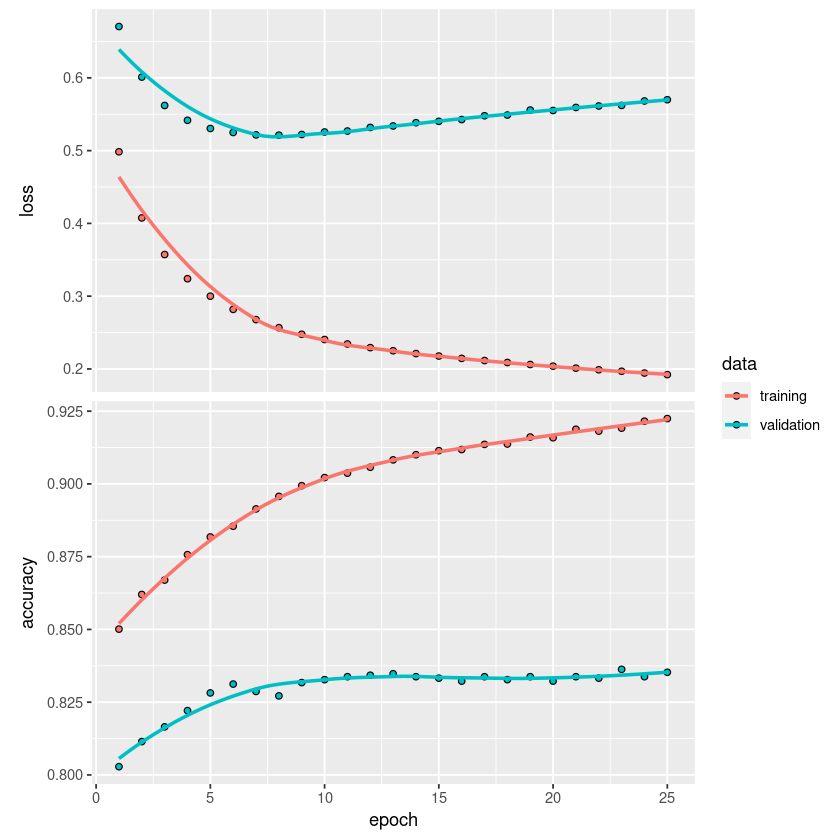

In [19]:
model_2 <- keras_model_sequential() %>%
  layer_dense(units = 32, activation = "relu", input_shape = n_cols) %>%
  layer_dense(units = 1, activation = "sigmoid") %>% 
  compile(
    optimizer = optimizer_sgd(lr = 0.01),
    loss = 'binary_crossentropy',
    metrics = c('accuracy'),
    )

# Fit model
set.seed(42)
history <- model_2 %>%
  fit(
    x = X_train,
    y = Y_train,
    epochs = 25,
    batch_size = 32,
    validation_split = 0.2,
    verbose = FALSE
  )

history

plot(history)

model_2 %>% evaluate(X_test, Y_test, batch_size = 128)

### Evaluación en test

In [20]:
data_to_eval = X_test
real_target = Y_test
pred_intention <- predict(model_2, data_to_eval)

confusionMatrix(data = as.factor(ifelse(pred_intention>0.5, 1, 0)),
                reference = as.factor(real_target),
                positive='1',
                mode='prec_recall'
               )

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2002  216
         1   82  165
                                          
               Accuracy : 0.8791          
                 95% CI : (0.8656, 0.8917)
    No Information Rate : 0.8454          
    P-Value [Acc > NIR] : 1.065e-06       
                                          
                  Kappa : 0.4598          
                                          
 Mcnemar's Test P-Value : 1.314e-14       
                                          
              Precision : 0.66802         
                 Recall : 0.43307         
                     F1 : 0.52548         
             Prevalence : 0.15456         
         Detection Rate : 0.06694         
   Detection Prevalence : 0.10020         
      Balanced Accuracy : 0.69686         
                                          
       'Positive' Class : 1               
                                          

## Modelo 3
Ahora en podemos explorar que pasa si aumentamos el numero de neuronas.


Final epoch (plot to see history):
        loss: 0.1802
    accuracy: 0.9284
    val_loss: 0.5543
val_accuracy: 0.8363 

`geom_smooth()` using formula 'y ~ x'



loss  accuracy 
0.3455825 0.8782961

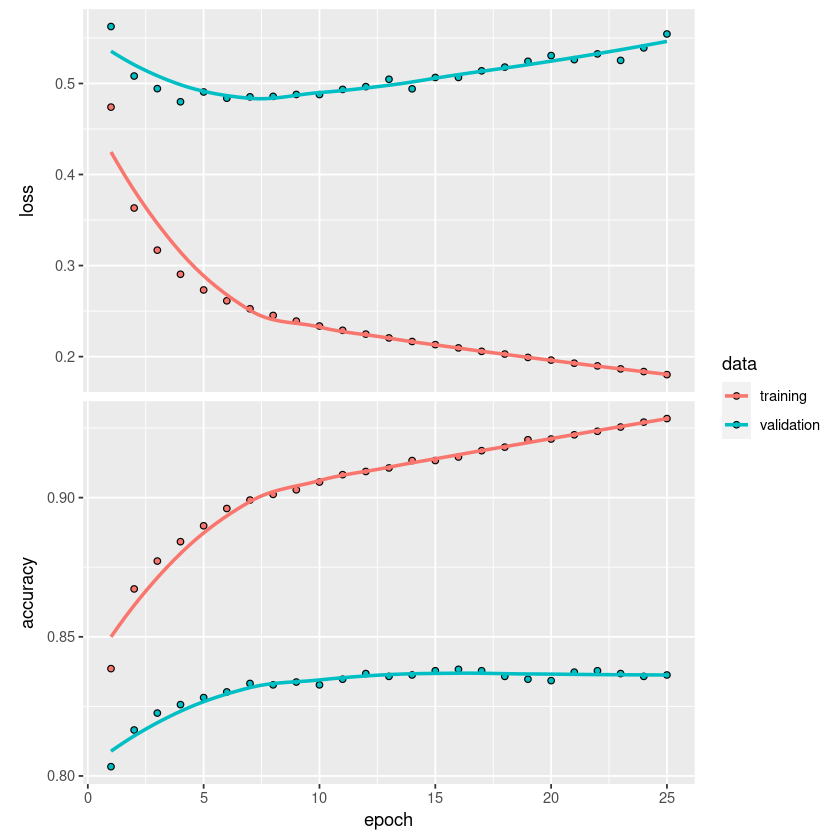

In [21]:
model_3 <- keras_model_sequential() %>%
  layer_dense(units = 256, activation = "relu", input_shape = n_cols) %>%
  layer_dense(units = 1, activation = "sigmoid") %>% 
  compile(
    optimizer = optimizer_sgd(lr = 0.01),
    loss = 'binary_crossentropy',
    metrics = c('accuracy'),
    )

# Fit model
set.seed(42)
history <- model_3 %>%
  fit(
    x = X_train,
    y = Y_train,
    epochs = 25,
    batch_size = 32,
    validation_split = 0.2,
    verbose = FALSE
  )

history

plot(history)

model_3 %>% evaluate(X_test, Y_test, batch_size = 128)

### Evaluacion en test

In [22]:
data_to_eval = X_test
real_target = Y_test
pred_intention <- predict(model_3, data_to_eval)

confusionMatrix(data = as.factor(ifelse(pred_intention>0.5, 1, 0)),
                reference = as.factor(real_target),
                positive='1',
                mode='prec_recall'
               )

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2017  233
         1   67  148
                                         
               Accuracy : 0.8783         
                 95% CI : (0.8647, 0.891)
    No Information Rate : 0.8454         
    P-Value [Acc > NIR] : 1.904e-06      
                                         
                  Kappa : 0.4335         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
              Precision : 0.68837        
                 Recall : 0.38845        
                     F1 : 0.49664        
             Prevalence : 0.15456        
         Detection Rate : 0.06004        
   Detection Prevalence : 0.08722        
      Balanced Accuracy : 0.67815        
                                         
       'Positive' Class : 1              
                                         

## Modelo 4
Ahora podemos aumentar el numero de capas a ver si logramos capturar realciones mas complejas en los datos que con solo 1 capa no es posible.


Final epoch (plot to see history):
        loss: 0.2308
    accuracy: 0.9067
    val_loss: 0.5371
val_accuracy: 0.8267 

`geom_smooth()` using formula 'y ~ x'



loss  accuracy 
0.3240622 0.8758621

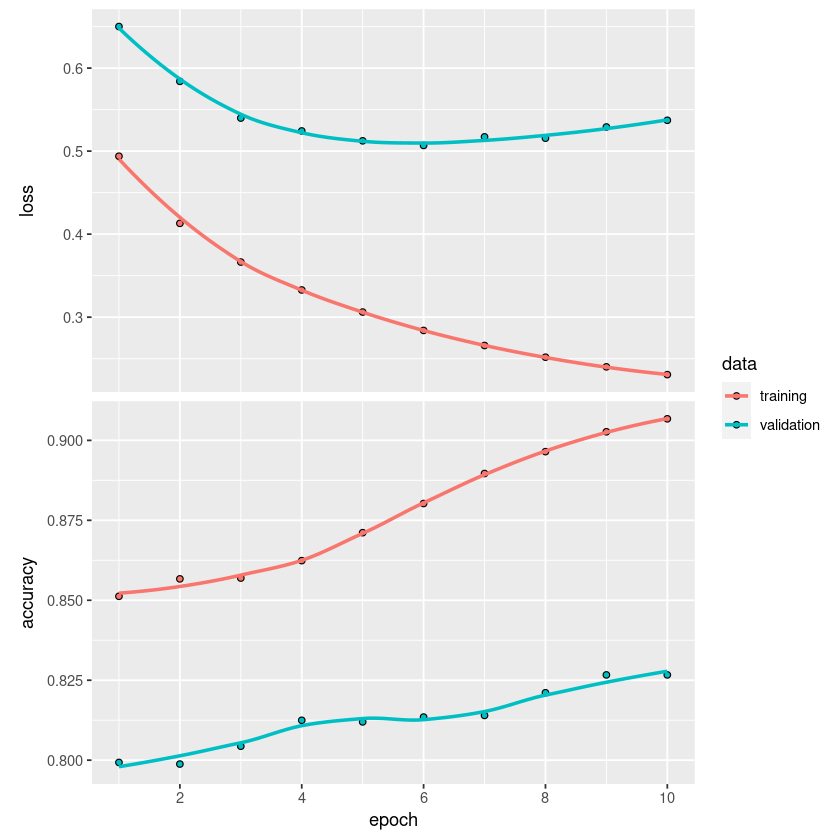

In [23]:
model_4 <- keras_model_sequential() %>%
  layer_dense(units = 32, activation = "relu", input_shape = n_cols) %>%
  layer_dense(units = 32, activation = "relu") %>%
  layer_dense(units = 1, activation = "sigmoid") %>% 
  compile(
    optimizer = optimizer_sgd(lr = 0.01),
    loss = 'binary_crossentropy',
    metrics = c('accuracy'),
    )

# Fit model
set.seed(42)
history <- model_4 %>%
  fit(
    x = X_train,
    y = Y_train,
    epochs = 10,
    batch_size = 32,
    validation_split = 0.2,
    #validation_data, 
    verbose = FALSE
  )

history

plot(history)

model_4 %>% evaluate(X_test, Y_test, batch_size = 128)

### Evaluación en test

In [24]:
data_to_eval = X_test
real_target = Y_test
pred_intention <- predict(model_4, data_to_eval)

confusionMatrix(data = as.factor(ifelse(pred_intention>0.5, 1, 0)),
                reference = as.factor(real_target),
                positive='1',
                mode='prec_recall'
               )

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2003  225
         1   81  156
                                          
               Accuracy : 0.8759          
                 95% CI : (0.8622, 0.8886)
    No Information Rate : 0.8454          
    P-Value [Acc > NIR] : 9.960e-06       
                                          
                  Kappa : 0.4383          
                                          
 Mcnemar's Test P-Value : 2.964e-16       
                                          
              Precision : 0.65823         
                 Recall : 0.40945         
                     F1 : 0.50485         
             Prevalence : 0.15456         
         Detection Rate : 0.06329         
   Detection Prevalence : 0.09615         
      Balanced Accuracy : 0.68529         
                                          
       'Positive' Class : 1               
                                          

## Early stop

In [21]:
model_2 <- keras_model_sequential() %>%
  layer_dense(units = 128, activation = "relu", input_shape = n_cols) %>%
  layer_dense(units = 128, activation = "relu") %>%
  layer_dense(units = 1, activation = "sigmoid") %>% 
  compile(
    optimizer = optimizer_sgd(lr = 0.01),
    loss = 'binary_crossentropy',
    metrics = c('accuracy'),
    )

# Fit model
set.seed(42)
history <- model_2 %>%
  fit(
    x = X_train,
    y = Y_train,
    epochs = 100,
    batch_size = 32,
    validation_split = 0.2,
    callbacks = c(callback_early_stopping(patience = 10)),
    verbose = FALSE
  )

history


Final epoch (plot to see history):
        loss: 0.1899
    accuracy: 0.9241
    val_loss: 0.5617
val_accuracy: 0.8449 

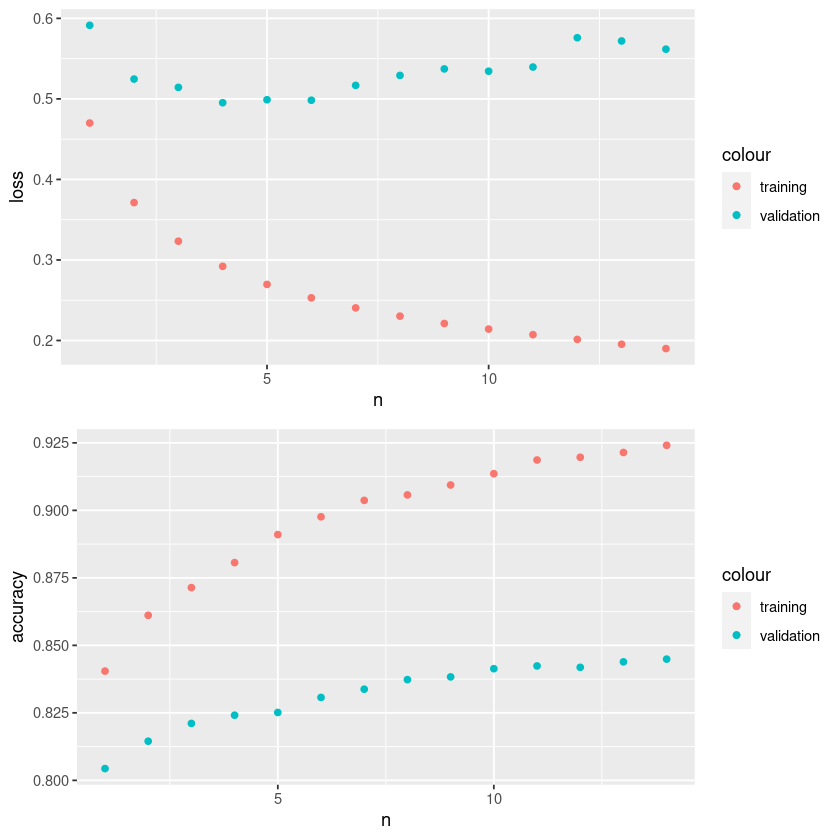

In [22]:
history_data <- as.data.frame(history$metrics) %>% 
    mutate(n = row_number())
p1 <- history_data %>% 
    ggplot(aes(n, loss)) +
        geom_point(aes(color='training')) +
        geom_point(aes(n, val_loss, color='validation'))
        

p2 <- history_data %>% 
    ggplot(aes(n, accuracy)) +
        geom_point(aes(color='training')) + 
        geom_point(aes(n, val_accuracy, color='validation')) 

gridExtra::grid.arrange(p1, p2, ncol = 1)

## Mejor modelo
A pesar de las diferentes combonaciones que probamos la configuración inicial fue una de las que mejor resutlado nos dio. Quiza para mejorar el performance del modelo necesitamos mas features que puedan explicar mejor el problema y otra opcion es darle mas observaciones para que el modelo tenga mas información al momento de hacer el entrenamiento


Final epoch (plot to see history):
        loss: 0.1731
    accuracy: 0.9317
    val_loss: 0.5732
val_accuracy: 0.8388 

`geom_smooth()` using formula 'y ~ x'



loss  accuracy 
0.3468844 0.8803245

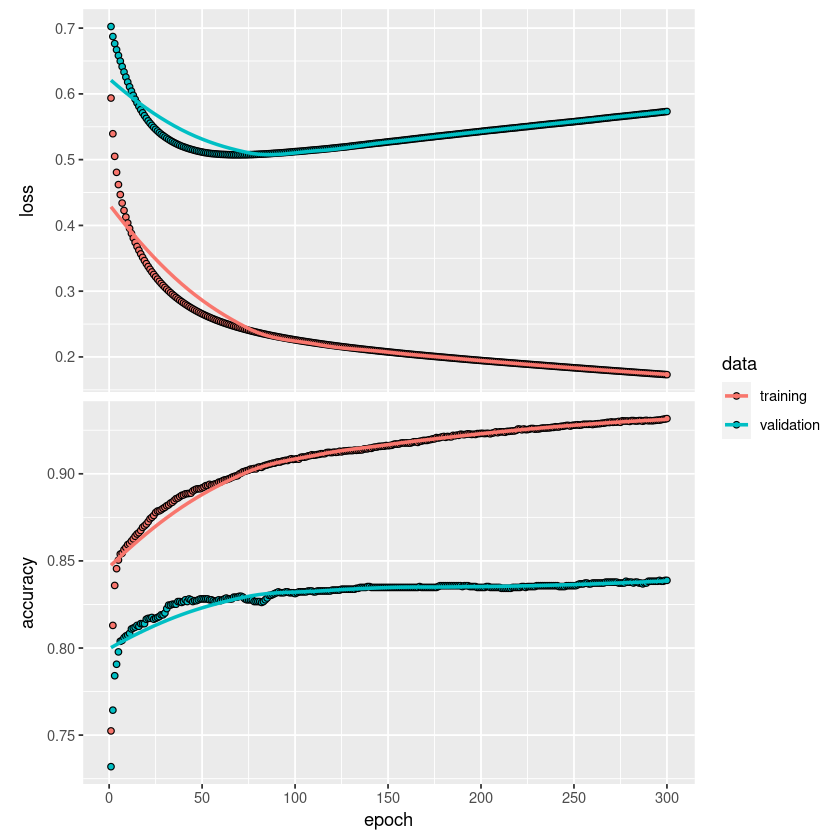

In [23]:
model_best <- keras_model_sequential() %>%
  layer_dense(units = 32, activation = "relu", input_shape = n_cols) %>%
  layer_dense(units = 1, activation = "sigmoid") %>% 
  compile(
    optimizer = optimizer_sgd(lr = 0.001),
    loss = 'binary_crossentropy',
    metrics = c('accuracy'),
    )

# Fit model
set.seed(42)
history <- model_best %>%
  fit(
    x = X_train,
    y = Y_train,
    epochs = 300,
    batch_size = 32,
    validation_split = 0.2,
    verbose = FALSE
  )

history

plot(history)

model_best %>% evaluate(X_test, Y_test, batch_size = 32)

### Evaluación en test

In [28]:
data_to_eval = X_test
real_target = Y_test
pred_intention <- predict(model_best, data_to_eval)

confusionMatrix(data = as.factor(ifelse(pred_intention>0.5, 1, 0)),
                reference = as.factor(real_target),
                positive='1',
                mode='prec_recall'
               )

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2006  204
         1   78  177
                                          
               Accuracy : 0.8856          
                 95% CI : (0.8724, 0.8979)
    No Information Rate : 0.8454          
    P-Value [Acc > NIR] : 5.953e-09       
                                          
                  Kappa : 0.4939          
                                          
 Mcnemar's Test P-Value : 9.795e-14       
                                          
              Precision : 0.69412         
                 Recall : 0.46457         
                     F1 : 0.55660         
             Prevalence : 0.15456         
         Detection Rate : 0.07181         
   Detection Prevalence : 0.10345         
      Balanced Accuracy : 0.71357         
                                          
       'Positive' Class : 1               
                                          

# ANN en imagenes
Las redes neuronales no son muy famosas en data tabular porque otras tecnicas como RF o XGBoost obtienen mejores resultados en dataset pequeños y medianos, pero en el caso de datos no estructurados y mas complejos como las imagenes, audio y lenguajes las redes neuronales han tenido un desempeño excepcional.

In [36]:
#loading the keras inbuilt mnist dataset
data<-dataset_mnist()

#separating train and test file
train_x<-data$train$x
train_y<-data$train$y
test_x<-data$test$x
test_y<-data$test$y

rm(data)

In [37]:
class(train_x)

[1] "array"

In [38]:
dim(train_x)

[1] 60000    28    28

[1] 0

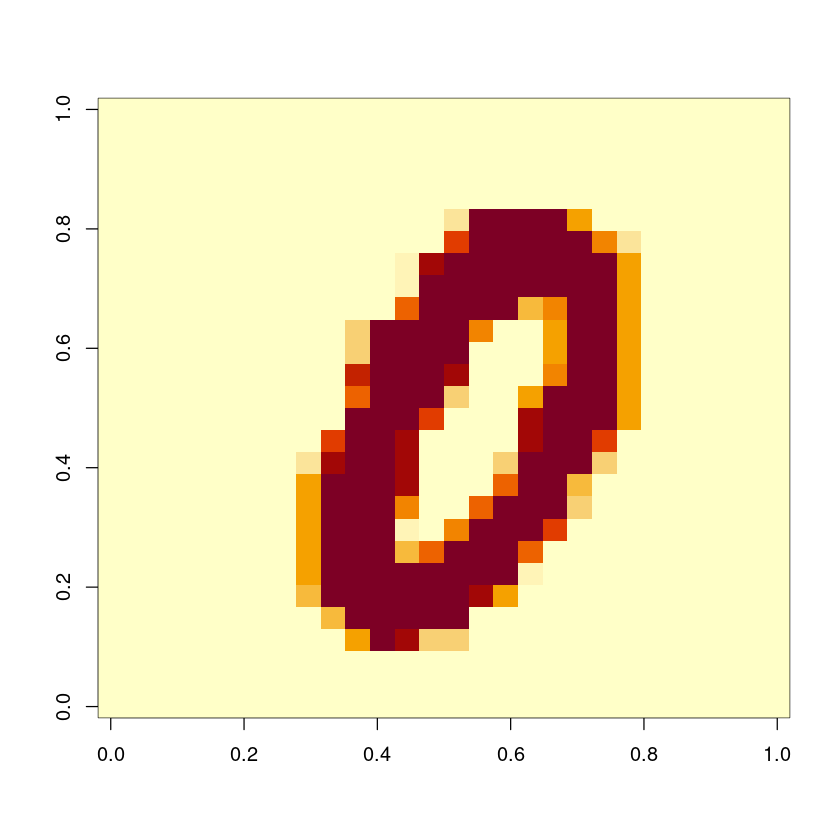

In [39]:
idx <- 35
train_y[idx]
num_img <- train_x[idx,28:1,1:28]

image(t(num_img))

Con el objetivo de usar nuestra red neuronal necesitamos pasar la imagen 2D a un vector 1D y escalar la data entre 0 y 1. 

In [40]:
train_x <- array(train_x, dim = c(dim(train_x)[1], prod(dim(train_x)[-1]))) / 255
test_x <- array(test_x, dim = c(dim(test_x)[1], prod(dim(test_x)[-1]))) / 255

In [41]:
dim(train_x)

[1] 60000   784

Keras tiene una funcion para pasar las distintas etiquetas de un problema de multicategorias a un vector de valores unicos que es un requisito del formato de salida del modelo.

In [42]:
train_y

[1] 5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5
   [37] 6 0 7 6 1 8 7 9 3 9 8 5 9 3 3 0 7 4 9 8 0 9 4 1 4 4 6 0 4 5 6 1 0 0 1 7
   [73] 1 6 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3
  [109] 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4 1 6 3 4 5 9 1 3 3 8 5 4 7 7 4 2
  [145] 8 5 8 6 7 3 4 6 1 9 9 6 0 3 7 2 8 2 9 4 4 6 4 9 7 0 9 2 9 5 1 5 9 1 2 3
  [181] 2 3 5 9 1 7 6 2 8 2 2 5 0 7 4 9 7 8 3 2 1 1 8 3 6 1 0 3 1 0 0 1 7 2 7 3
  [217] 0 4 6 5 2 6 4 7 1 8 9 9 3 0 7 1 0 2 0 3 5 4 6 5 8 6 3 7 5 8 0 9 1 0 3 1
  [253] 2 2 3 3 6 4 7 5 0 6 2 7 9 8 5 9 2 1 1 4 4 5 6 4 1 2 5 3 9 3 9 0 5 9 6 5
  [289] 7 4 1 3 4 0 4 8 0 4 3 6 8 7 6 0 9 7 5 7 2 1 1 6 8 9 4 1 5 2 2 9 0 3 9 6
  [325] 7 2 0 3 5 4 3 6 5 8 9 5 4 7 4 2 7 3 4 8 9 1 9 2 8 7 9 1 8 7 4 1 3 1 1 0
  [361] 2 3 9 4 9 2 1 6 8 4 7 7 4 4 9 2 5 7 2 4 4 2 1 9 7 2 8 7 6 9 2 2 3 8 1 6
  [397] 5 1 1 0 2 6 4 5 8 3 1 5 1 9 2 7 4 4 4 8 1 5 8 9 5 6 7 9 9 3 7 0 9 0 6 6
  [433] 2 3 9 0 7 5 4 8 0 9 4 1 2 8 7 1 2 6 1 0 3 0 1 1 8 2 0 3 9 4 0 5 0 6 1 7
  [469] 7 8 1 9 2 0 5 1 2 2 7 3 5 4 9 7 1 8 3 9 6 0 3 1 1 2 6 3 5 7 6 8 3 9 5 8
  [505] 5 7 6 1 1 3 1 7 5 5 5 2 5 8 7 0 9 7 7 5 0 9 0 0 8 9 2 4 8 1 6 1 6 5 1 8
  [541] 3 4 0 5 5 8 3 6 2 3 9 2 1 1 5 2 1 3 2 8 7 3 7 2 4 6 9 7 2 4 2 8 1 1 3 8
  [577] 4 0 6 5 9 3 0 9 2 4 7 1 2 9 4 2 6 1 8 9 0 6 6 7 9 9 8 0 1 4 4 6 7 1 5 7
  [613] 0 3 5 8 4 7 1 2 5 9 5 6 7 5 9 8 8 3 6 9 7 0 7 5 7 1 1 0 7 9 2 3 7 3 2 4
  [649] 1 6 2 7 5 5 7 4 0 2 6 3 6 4 0 4 2 6 0 0 0 0 3 1 6 2 2 3 1 4 1 5 4 6 4 7
  [685] 2 8 7 9 2 0 5 1 4 2 8 3 2 4 1 5 4 6 0 7 9 8 4 9 8 0 1 1 0 2 2 3 2 4 4 5
  [721] 8 6 5 7 7 8 8 9 7 4 7 3 2 0 8 6 8 6 1 6 8 9 4 0 9 0 4 1 5 4 7 5 3 7 4 9
  [757] 8 5 8 6 3 8 6 9 9 1 8 3 5 8 6 5 9 7 2 5 0 8 5 1 1 0 9 1 8 6 7 0 9 3 0 8
  [793] 8 9 6 7 8 4 7 5 9 2 6 7 4 5 9 2 3 1 6 3 9 2 2 5 6 8 0 7 7 1 9 8 7 0 9 9
  [829] 4 6 2 8 5 1 4 1 5 5 1 7 3 6 4 3 2 5 6 4 4 0 4 4 6 7 2 4 3 3 8 0 0 3 2 2
  [865] 9 8 2 3 7 0 1 1 0 2 3 3 8 4 3 5 7 6 4 7 7 8 5 9 7 0 3 1 6 2 4 3 4 4 7 5
  [901] 9 6 9 0 7 1 4 2 7 3 6 7 5 8 4 5 5 2 7 1 1 5 6 8 5 8 4 0 7 9 9 2 9 7 7 8
  [937] 7 4 2 6 9 1 7 0 6 4 2 5 7 0 7 1 0 3 7 6 5 0 6 1 5 1 7 8 5 0 3 4 7 7 5 7
  [973] 8 6 9 3 8 6 1 0 9 7 1 3 0 5 6 4 4 2 4 4 3 1 7 7 6 0 3 6 0 7 1 1 4 9 4 3
 [1009] 4 8 2 2 1 8 7 0 8 1 0 7 6 3 7 7 5 8 8 9 0 0 4 1 5 2 2 3 9 4 9 5 0 6 7 7
 [1045] 1 8 0 2 2 0 4 1 1 2 7 3 9 7 2 8 1 9 5 8 8 1 9 8 3 1 6 5 7 4 2 7 0 3 0 4
 [1081] 1 1 7 9 1 1 8 5 7 5 0 6 6 0 4 1 2 3 4 4 6 8 0 9 5 8 7 0 3 5 4 5 9 6 7 1
 [1117] 9 6 1 3 8 3 9 1 2 7 7 7 0 2 3 1 1 4 2 5 6 0 9 6 2 8 9 2 3 3 6 9 1 4 3 3
 [1153] 0 7 7 1 7 7 3 6 4 9 5 4 4 2 7 9 0 9 8 4 4 9 1 2 4 9 3 0 4 1 6 2 6 3 7 4
 [1189] 2 6 6 7 1 8 9 0 4 1 4 2 1 3 6 4 6 7 5 8 7 0 5 1 4 2 8 4 7 7 3 8 4 9 5 8
 [1225] 6 7 3 4 6 7 1 7 4 3 3 9 8 8 1 8 6 3 1 1 3 5 2 8 4 2 9 7 1 4 8 2 9 6 4 1
 [1261] 3 4 2 5 2 5 6 8 0 6 2 4 9 4 9 4 5 1 5 8 4 7 9 5 9 5 9 1 5 8 3 9 9 1 8 3
 [1297] 8 6 5 2 7 2 7 6 0 9 7 9 4 6 0 5 3 5 7 3 9 3 6 8 3 1 7 6 5 5 7 6 5 8 2 1
 [1333] 7 9 2 7 3 6 7 8 5 3 7 7 8 4 0 7 3 0 6 3 9 7 1 9 5 3 6 0 9 2 8 0 9 1 6 0
 [1369] 0 1 9 0 0 4 2 1 7 0 3 4 4 7 5 9 8 2 0 0 8 6 2 2 7 6 1 2 9 2 6 9 7 9 5 0
 [1405] 8 1 5 2 4 3 9 4 7 5 6 6 7 7 6 8 5 9 7 0 6 1 9 2 3 3 5 4 3 5 8 6 3 7 2 8
 [1441] 4 9 5 0 2 1 4 2 4 3 1 7 1 8 0 9 6 8 1 9 4 4 9 1 8 9 6 5 5 3 3 0 1 4 3 8
 [1477] 3 4 2 0 7 5 5 1 8 5 3 4 6 0 5 7 2 6 6 0 1 1 4 7 9 0 0 6 6 8 6 9 4 5 2 4
 [1513] 0 7 5 6 5 0 9 8 6 1 9 7 5 7 5 1 1 3 0 2 0 3 8 1 6 4 6 2 6 4 8 8 1 4 4 7
 [1549] 1 2 2 3 9 6 4 9 5 6 2 3 9 2 6 2 7 4 3 6 4 9 7 0 2 2 9 5 4 5 0 1 4 3 6 3
 [1585] 2 9 7 5 3 7 0 9 5 8 3 2 0 1 8 3 0 1 2 3 4 0 0 1 7 2 9 3 9 4 2 5 8 6 7 7
 [1621] 9 8 9 9 2 0 0 1 4 2 4 3 9 4 3 5 7 6 5 7 1 8 6 9 3 0 4 1 2 2 5 3 7 4 1 7
 [1657] 7 8 1 9 2 3 2 4 0 1 8 4 3 6 5 6 4 7 9 3 1 3 0 2 1 1 0 9 9 4 6 7 6 3 5 5
 [1693] 4 4 6 9 1 1 3 1 1 0 5 1 4 4 6 6 6 0 1 2 0 8 2 2 1 1 3 7 9 5 3 0 2 0 6 2
 [1729] 9 0 7 6 9 9 1 2 9 3 4 7 9 6 0 9 4 8 7 7 9 8 6 9 5 2 2 2 3 9 8 8 8 6 4 4
 [1765] 4 4 2 4 6 0 7 0 7 8 2 0 8 8 3 6 8 6 6 8 6 5 1 1 8 7 8 3 6 8 9 5 0 0 0 3
 [18

In [43]:
train_y<-to_categorical(train_y,10)
test_y<-to_categorical(test_y,10)

In [44]:
train_y[2,]

[1] 1 0 0 0 0 0 0 0 0 0

In [45]:
model_img  <- keras_model_sequential() %>% 
  layer_dense(units = 784, input_shape = 784, activation = 'relu') %>%
  layer_dense(units = 10, activation = 'softmax') %>% 
  compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = c('accuracy')
  )


history <- model_img %>% fit(train_x, train_y, epochs = 40, batch_size = 128)

model_img %>% evaluate(test_x, test_y, batch_size = 128)

loss   accuracy 
0.08487988 0.98519999

`geom_smooth()` using formula 'y ~ x'



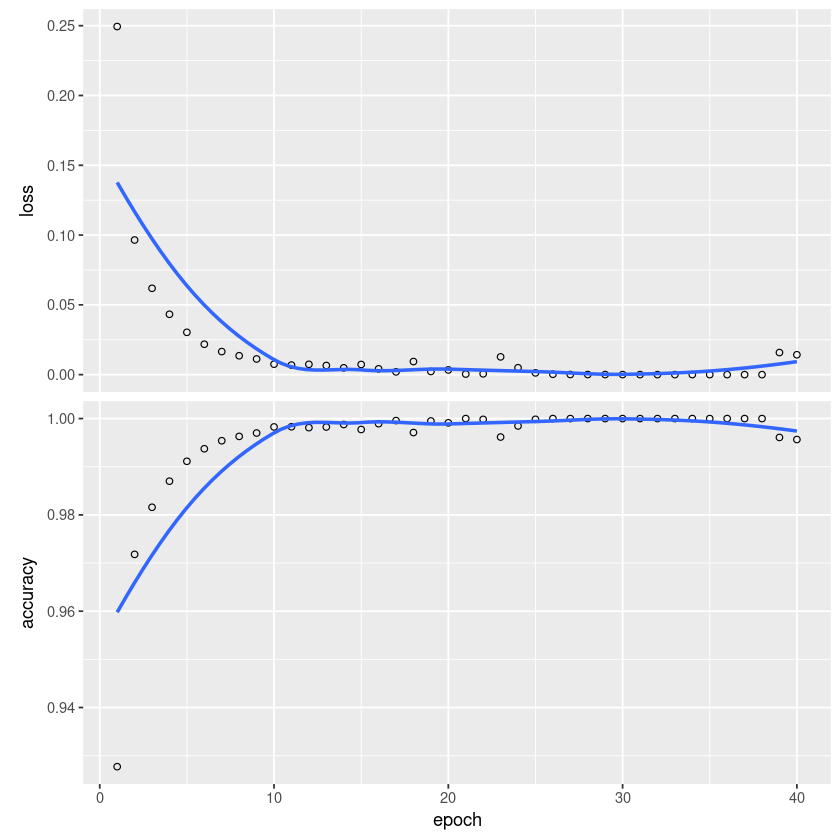

In [36]:
plot(history)

In [37]:
model_img  <- keras_model_sequential() %>% 
  layer_dense(units = 784, input_shape = 784, activation = 'relu') %>%
  layer_dense(units = 1024, input_shape = 784, activation = 'relu') %>%
  layer_dense(units = 10, activation = 'softmax') %>% 
  compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = c('accuracy')
  )


history <- model_img %>% fit(train_x, train_y, epochs = 40, batch_size = 128)

model_img %>% evaluate(test_x, test_y, batch_size = 128)

loss accuracy 
0.154264 0.980800

`geom_smooth()` using formula 'y ~ x'



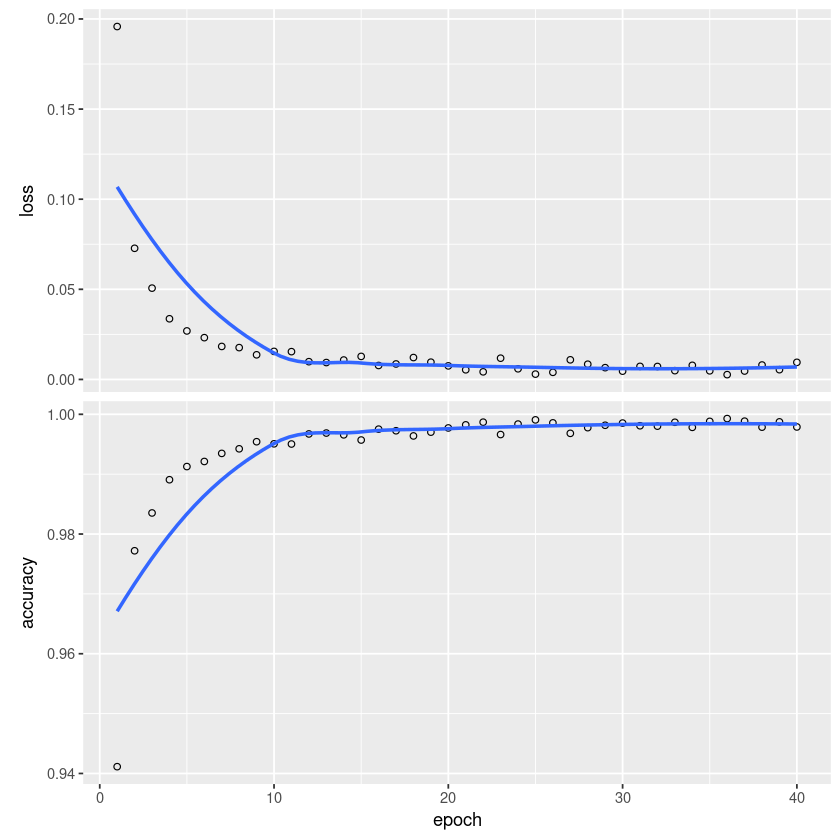

In [38]:
plot(history)

# Resumen
* Normalizar la data
* Denifir la topologia de la red
* Elegir el oprimizador 
* Entrenar
* Experimentar con los hiper-parametros

# Neural Network Zoo
<img src="https://www.asimovinstitute.org/wp-content/uploads/2019/04/NeuralNetworkZoo20042019.png">